Importing the necessary libraries

In [ ]:
!pip install yfinance
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29089 sha256=2b5724e7e82e3bf86e0d2dadbab62ebcdcb1406d7428de52b932f31764ed8308
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [ ]:



from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

For event based backtesting, an imporatant concept is a bar. A bar is unit of data or information. A bar represents an event.

Event based Backtesting will be based on new bars coming at not on full dataset.

First we will build a commonclass, this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

In [ ]:
class Common_Class():

    def __init__(self, symbol, start, end, interval, capital, transaction_cost, verbose = True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.capital = capital
        self.transaction_cost = transaction_cost
        self.verbose = verbose

        self.initial_capital = capital
        self.quantity = {}
        self.position = {}
        self.all_data = {}
        self.stock_capital = {}
        self.trades = 0
        self.trade_data = pd.DataFrame(columns=["trade", "date", "position", "price", "symbol", "quantity", "capital"])

        self.final_result_data = {}
        self.stored_data = pd.DataFrame()
        self.prepare_data()


    def prepare_data(self):
        for symbol in self.symbol:
            stock_data =  yf.Ticker(symbol).history(
                start = self.start,
                end = self.end,
                interval = self.interval
            )
            stock_data['Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
            stock_data = stock_data.dropna()
            self.all_data[symbol] = stock_data[["Close", "Return"]]
            self.quantity[symbol] = 0
            self.position[symbol] = 0
            self.stock_capital[symbol] = self.initial_capital / len(self.symbol)


    def close_graph(self):
        plt.figure(figsize=(15, 5))
        for stock, data in self.all_data.items():
            plt.plot(data["Close"], label=f"{stock} Price", linestyle="dashed")
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Price of Stocks")
        plt.legend()
        plt.grid()
        plt.show()


    def store_results(self, trade, date, position, price, symbol, quantity, capital):
        trade_detail = pd.DataFrame(
            {
                'trade': pd.Series(trade),
                'date': pd.Series(date),
                'position': pd.Series(position),
                'price': pd.Series(price),
                'symbol': pd.Series(symbol),
                'quantity': pd.Series(quantity),
                'capital': pd.Series(capital),
            }
        )
        self.stored_data = pd.concat([self.stored_data, trade_detail])


    # This function simply returns the date and prevailing price of the given asset when
    # a numerical input 'bar' is given which is just the index value.
    def return_date_price(self, stock, bar):
        date = str(self.all_data[stock].index[bar])[:10]
        price = self.all_data[stock].Close.iloc[bar]
        return date, price


    def realised_balance(self, bar, verbose = True):
        date, _ = self.return_date_price(self.symbol[0], bar)

        if verbose:
          print("Date: {} | Realised Balance: {:0.2f}".format(date, self.capital))

        return self.capital


    # This function sums up our entire portfolio value by multiplying the stock quantities
    # with the prevailing price for the given bar (i.e index or datetime)
    def unrealised_balance(self, bar, verbose = True):
        balance = 0
        for stock in self.symbol:
            date, price = self.return_date_price(stock, bar)
            balance += self.quantity[stock] * price

        if verbose:
          print("Date: {} | Unrealised Balance: {:0.2f}".format(date, balance))

        return balance


    # The sum of our portfolio value and our realised capital
    def total_balance(self, bar, verbose=True):
        date, _ = self.return_date_price(self.symbol[0], bar)
        balance = self.realised_balance(bar, verbose) + self.unrealised_balance(bar, verbose)

        if verbose:
          print("Date: {} | Total Balance: {:0.2f}".format(date, balance))

        return balance


    def buy_order(self, stock, bar, quantity = None, dollar = None):
        date, price = self.return_date_price(stock, bar)
        if quantity == None:
            quantity = int(dollar / price)
        self.capital -= quantity * price * (1 + self.transaction_cost)
        self.stock_capital[stock] -= quantity * price * (1 + self.transaction_cost)
        self.quantity[stock] += quantity
        self.trades += 1

        # Logs the buy order into a dataframe
        self.store_results(
            self.trades,                                                # An incremental value when we print stored_results df
            date,                                                       # Date at which the asset was bought
            self.position[stock],                                       # Buy symbol
            price,                                                      # Prevailing bid price
            stock,                                                      # Stock symbol
            quantity,                                                   # Qty bought
            self.quantity[stock] * price + self.stock_capital[stock]    # Total asset value
        )

        if self.verbose:
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(
                quantity, stock, price, quantity * price))
            # self.realised_balance(bar)
            # self.unrealised_balance(bar)
            self.total_balance(bar)


    def sell_order(self, stock, bar, quantity = None, dollar = None):
        date, price = self.return_date_price(stock, bar)
        if quantity == None:
            quantity = int(dollar / price)
        self.capital += quantity * price * (1 - self.transaction_cost)
        self.stock_capital[stock] += quantity * price * (1 - self.transaction_cost)
        self.quantity[stock] -= quantity
        self.trades += 1

        # Logs the sell order into a dataframe
        self.store_results(
            self.trades,                                                # An incremental value when we print stored_results df
            date,                                                       # Date at which the asset was bought
            self.position[stock],                                       # Sell symbol
            price,                                                      # Prevailing bid price
            stock,                                                      # Stock symbol
            quantity,                                                   # Qty bought
            self.quantity[stock] * price + self.stock_capital[stock]    # Total asset value
        )

        if self.verbose:
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(
                quantity, stock, price, quantity * price))
            # self.realised_balance(bar)
            # self.unrealised_balance(bar)
            self.total_balance(bar)


    def last_trade(self, stock, bar):
        date, price = self.return_date_price(stock, bar)
        last_quantity = self.quantity[stock]
        self.capital += self.quantity[stock] * price
        self.stock_capital[stock] += self.quantity[stock] * price
        self.quantity[stock] = 0
        self.trades += 1

        # Logs the final trade into a dataframe
        self.store_results(
            self.trades,                                                # An incremental value when we print stored_results df
            date,                                                       # Date at which the asset was bought
            self.position[stock],                                       # Sell symbol
            price,                                                      # Prevailing bid price
            stock,                                                      # Stock symbol
            last_quantity,                                              # Final Qty
            self.quantity[stock] * price + self.stock_capital[stock]    # Total asset value
        )

        if self.verbose:
            print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f}".format(
                last_quantity, stock, price, last_quantity * price))
            self.total_balance(bar)

    def performance_plots(self):
        final_result_data = self.final_result_data
        interval = str(self.interval)
        f, ax = plt.subplots(2, 3, figsize=(20, 10))

        # plot 1: Cumulative Returns of Stock
        plt.subplot(2, 3, 1)
        for stock in self.symbol:
            plt.plot(self.all_data[stock]['Return'].cumsum(), label = '{}'.format(stock), linestyle='dashed')
        plt.title("Cum Log Returns of Included Stocks")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # plot 2: Histogram of strategy return
        plt.subplot(2, 3, 2)
        plt.hist(final_result_data["log_returns"], bins=15, label="Strategy Returns", linestyle="dashed")
        plt.title("Histogram of Strategy Returns")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # plot 3: Strategy vs Market
        plt.subplot(2, 3, 3)
        plt.plot(final_result_data['gross_cum_returns'].dropna(), label='Strategy Cumulative Returns')
        plt.plot(final_result_data["market_gross_cum_returns"].dropna(), label="Benchmark Returns", color="green", linestyle="dashed")
        plt.plot(final_result_data['Total_Stock_Returns_cum_sum'], color='red', label="Equal weighted stock returns", linestyle='dashed')
        plt.title("Strategy vs Market")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # plot 4: Drawdown
        plt.subplot(2, 3, 4)
        plt.plot(final_result_data['gross_cum_returns'].dropna(), label='Cumulative Returns')
        plt.plot(final_result_data['cum_max'].dropna(), label='Cumulative Maximum')
        plt.title("Drawdown")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # plot 5: Equity Curve
        plt.subplot(2, 3, 5)
        plt.plot(final_result_data['capital'].dropna(), label="Equity $")
        plt.title("Equity Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        plt.suptitle("Performance Plots")
        plt.show()


In [ ]:
class MA_Strategy(Common_Class):

    def __init__(self, symbol, benchmark, start, end, interval, capital, transaction_cost, verbose = True):
      self.strategy_daily_capital = pd.DataFrame(columns=["date", "capital"])
      self.benchmark = benchmark
      super().__init__(symbol, start, end, interval, capital, transaction_cost, verbose)


    def store_ending_capital_for_day(self, bar):
        date, _ = self.return_date_price(self.symbol[0], bar)
        df = self.strategy_daily_capital.copy()
        df.loc[len(df)] = [date, self.total_balance(bar, False)]
        self.strategy_daily_capital = df


    def go_long(self, stock, bar, quantity = None, dollar = None):
        if self.position[stock] == -1:
            self.buy_order(stock, bar, quantity = -self.quantity[stock])
        if quantity:
            self.buy_order(stock, bar, quantity = quantity)
        elif dollar:
            if dollar == "all":
                dollar = self.stock_capital[stock]
            self.buy_order(stock, bar, dollar = dollar)


    def go_short(self, stock, bar, quantity = None, dollar = None):
        if self.position[stock] == 1:
            self.sell_order(stock, bar, quantity = self.quantity[stock])
        if quantity:
            self.sell_order(stock, bar, quantity = quantity)
        elif dollar:
            if dollar == "all":
                dollar = self.stock_capital[stock]
            self.sell_order(stock, bar, dollar = dollar)


    def run_strategy(self, STMA_window, LTMA_window):
        for stock in self.symbol:
            indicator_1 = SMAIndicator(
                close = self.all_data[stock]["Close"],
                window = STMA_window,
                fillna = False
            )
            STMA = indicator_1.sma_indicator()
            self.all_data[stock]["STMA"] = STMA

            indicator_2 = SMAIndicator(
                close = self.all_data[stock]["Close"],
                window = LTMA_window,
                fillna = False
            )
            LTMA = indicator_2.sma_indicator()
            self.all_data[stock]["LTMA"] = LTMA

        for bar in range(LTMA_window, len(self.all_data[self.symbol[0]])):
            for stock in self.symbol:
                if self.position[stock] in [0, -1]:
                    if self.all_data[stock]["STMA"].iloc[bar] > self.all_data[stock]["LTMA"].iloc[bar]:
                        self.go_long(stock, bar, dollar="all")
                        self.position[stock] = 1
                        print("----------")

                if self.position[stock] in [0, 1]:
                    if self.all_data[stock]["STMA"].iloc[bar] < self.all_data[stock]["LTMA"].iloc[bar]:
                        self.go_short(stock, bar, dollar="all")
                        self.position[stock] = -1
                        print("----------")

            self.store_ending_capital_for_day(bar)

        print("----------")
        for stock in self.symbol:
            self.last_trade(stock, -1)

        self.performance()
        self.performance_plots()


    def performance(self):
        df = self.strategy_daily_capital
        df["date"] = pd.to_datetime(df["date"]).dt.date
        df = df.set_index("date")

        df["log_returns"] = np.log(df["capital"] / df["capital"].shift(1))
        df["gross_cum_returns"] = df["log_returns"].cumsum().apply(np.exp)
        df["cum_max"] = df["gross_cum_returns"].cummax()
        df["drawdown"] = df["cum_max"] - df["gross_cum_returns"]

        # add market benchmark return to df
        market_df = yf.Ticker(self.benchmark).history(start=self.start, end=self.end, interval=self.interval).reset_index()
        market_df["Date"] = pd.to_datetime(market_df["Date"]).dt.date
        market_df = market_df.set_index("Date")
        df["market_close"] = market_df["Close"]
        df["market_log_returns"] = np.log(df["market_close"] / df["market_close"].shift(1))
        df["market_gross_cum_returns"] = df["market_log_returns"].cumsum().apply(np.exp)
        df = df.reset_index()

        # Assuming the market returns are calculated using the average returns of all the stock in self.symbol
        mkt = pd.DataFrame()
        for stock in self.symbol:
            mkt['Returns_{}'.format(stock)] = self.all_data[stock]['Return']

        mkt['date'] = [str(dt)[:10] for dt in self.all_data[self.symbol[0]].index]
        mkt['date'] = pd.to_datetime(mkt['date']).dt.date
        mkt.set_index('date')
        mkt['Avg_Return'] = mkt.mean(axis=1)
        mkt['Total_Stock_Returns_cum_sum'] = mkt['Avg_Return'].cumsum()
        mkt = mkt.merge(df, on='date')
        df['Total_Stock_Returns_cum_sum'] = np.exp(mkt['Total_Stock_Returns_cum_sum'])

        print("-" * 10)
        print("Performance Metrics")

        # Total Balance
        print("The total capital at the end of strategy: ${:0.2f}".format(self.capital))

        # Annual Gross Expected Returns
        daily_log_mean_ret = df["log_returns"].mean()
        annual_log_return = 252 * daily_log_mean_ret
        annual_regular_return = (np.exp(annual_log_return) - 1) * 100
        print("The annual regular returns: {:0.2f}%".format(annual_regular_return))

        # Annual Std Deviation
        daily_regular_std = (np.exp(df["log_returns"]) - 1).std()
        annual_regular_std = daily_regular_std * (252 ** 0.5) * 100
        print("The annual regular standard deviation: {:0.2f}".format(annual_regular_std))

        # Annual Sharpe Ratio
        SR = annual_regular_return / annual_regular_std
        print("The annual Sharpe Ratio: {:0.2f}".format(SR))

        # Strategy Returns on Investment
        returns = (self.capital - self.initial_capital) / self.initial_capital * 100
        print("The returns on investment from {} to {} by this strategy is {:0.2f}".format(
            self.start,
            self.end,
            returns
        ))

        # Drawdown
        drawdown = df["drawdown"].max()
        print("The maximum drawdown: {:0.2f}%".format(drawdown * 100))

        zero_periods = df[df["drawdown"] == 0]
        deltas = (zero_periods.index[1:] - zero_periods.index[:-1])
        print("The maximum drawdown period: {:0.2f}".format(deltas.max()))

        # Annual Sortino Ratio
        neg_log_returns = np.where(df["log_returns"] < 0, df["log_returns"], 0)
        neg_regular_returns = np.exp(neg_log_returns) - 1

        daily_std_dev_sortino = np.std(neg_regular_returns)
        annual_std_dev_sortino = daily_std_dev_sortino * (252 ** 0.5) * 100
        sortino_ratio = annual_regular_return / annual_std_dev_sortino
        print("The annual Sortino Ratio: {:0.2f}".format(sortino_ratio))

        # Total trades
        print("The total trades made by the strategy: {}".format(self.trades))

        self.final_result_data = df

Sold 95 shares of META at 209.8 per share worth 19933.9 $
Date: 2020-02-04 | Realised Balance: 119734.51
Date: 2020-02-04 | Unrealised Balance: -19933.85
Date: 2020-02-04 | Total Balance: 99800.66
----------
Bought 257 shares of AAPL at 77.8 per share worth 19984.5 $
Date: 2020-02-04 | Realised Balance: 99550.14
Date: 2020-02-04 | Unrealised Balance: 50.67
Date: 2020-02-04 | Total Balance: 99600.82
----------
Bought 195 shares of AMZN at 102.5 per share worth 19984.3 $
Date: 2020-02-04 | Realised Balance: 79366.02
Date: 2020-02-04 | Unrealised Balance: 20034.95
Date: 2020-02-04 | Total Balance: 99400.97
----------
Bought 54 shares of NFLX at 369.0 per share worth 19926.5 $
Date: 2020-02-04 | Realised Balance: 59240.21
Date: 2020-02-04 | Unrealised Balance: 39961.49
Date: 2020-02-04 | Total Balance: 99201.71
----------
Bought 276 shares of GOOG at 72.4 per share worth 19969.6 $
Date: 2020-02-04 | Realised Balance: 39070.95
Date: 2020-02-04 | Unrealised Balance: 59931.06
Date: 2020-02-04

<ipython-input-4-5b5e0e0d07e3>:107: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mkt['Avg_Return'] = mkt.mean(axis=1)


----------
Performance Metrics
The total capital at the end of strategy: $76262.77
The annual regular returns: -17.00%
The annual regular standard deviation: 27.72
The annual Sharpe Ratio: -0.61
The returns on investment from 2020-01-01 to 2021-06-30 by this strategy is -23.74
The maximum drawdown: 57.85%
The maximum drawdown period: 20.00
The annual Sortino Ratio: -0.99
The total trades made by the strategy: 216


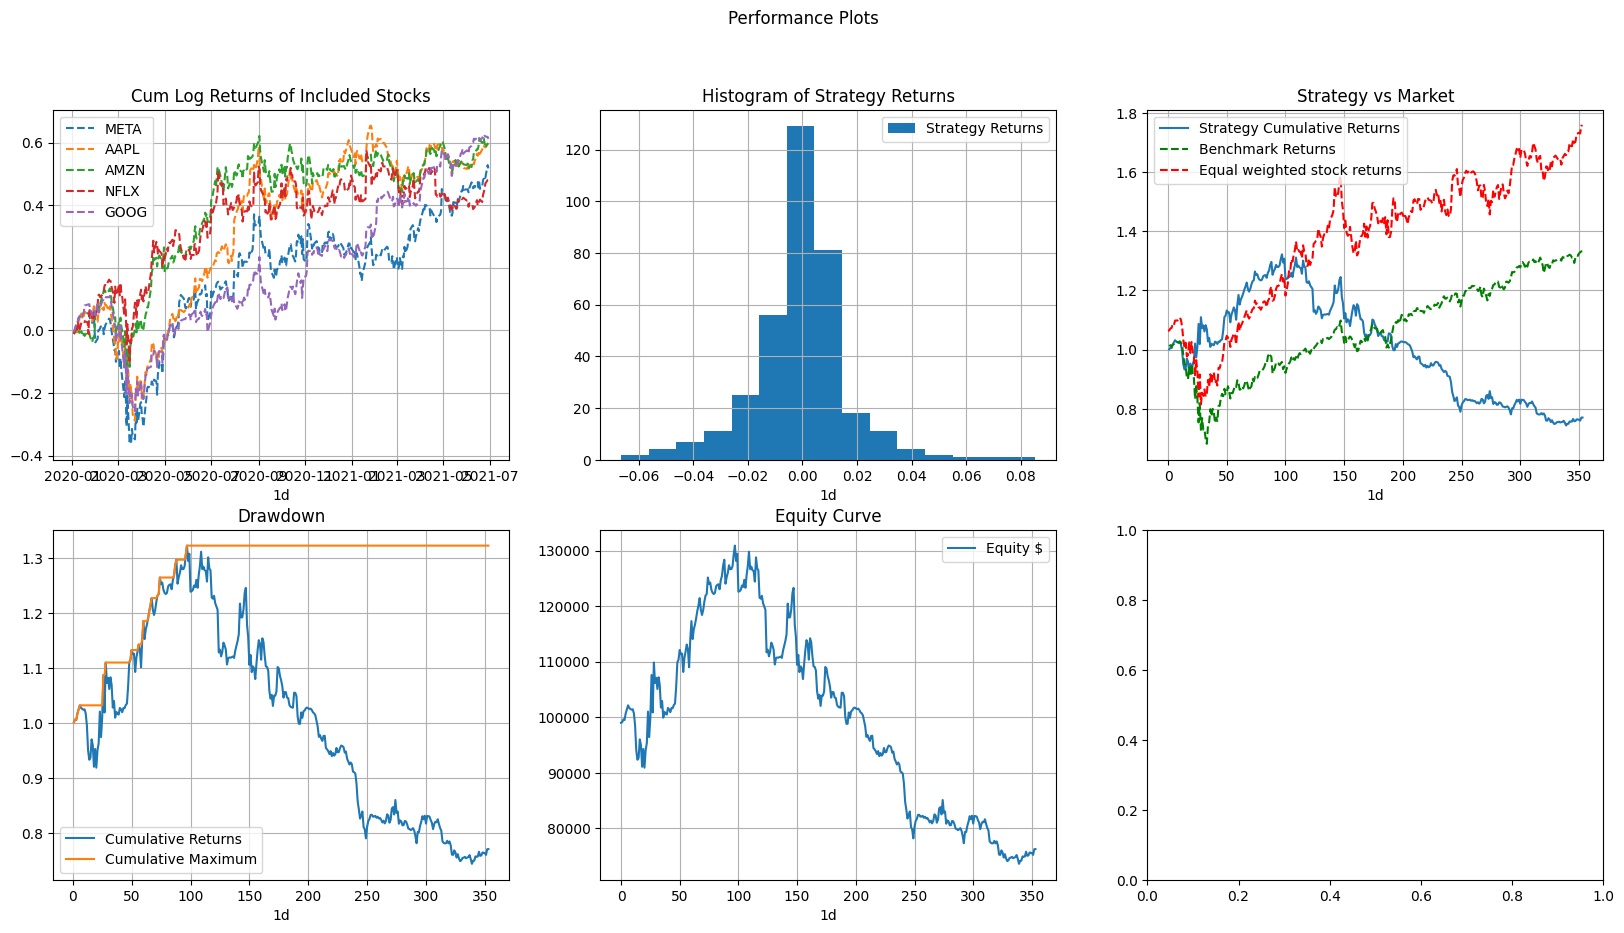

In [ ]:
stocks = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]
benchmark = "SPY"
start = "2020-01-01"
end = "2021-06-30"
interval = "1d"
capital = 100000
transaction_cost = 0.01
verbose = True

if __name__ == "__main__":
  A = MA_Strategy(stocks, benchmark, start, end, interval, capital, transaction_cost, verbose)
  A.run_strategy(5, 21)